In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=5, threshold=100, linewidth=100)

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from scipy.stats import multinomial

from pprint import pprint

In [2]:
D = 100 # 文書数
V = 20   # 語彙数

true_K = 6 # トピック数

In [3]:
# トピック分布のハイパーパラメータ
true_alpha = 1
true_alpha_k = [true_alpha] * true_K
#rng = np.random.default_rng()
#true_alpha_k = rng.uniform(low=1, high=2, size=true_K)

# トピック分布のパラメータを生成
true_theta_dk = np.random.dirichlet(alpha=true_alpha_k, size=D)

print("真の文書トピック分布 (D, K):")
pprint(true_theta_dk)

assert np.all(np.abs(true_theta_dk.sum(axis=1) - 1.0) < 1e-5)

真の文書トピック分布 (D, K):
array([[0.12849, 0.64909, 0.11261, 0.01666, 0.02722, 0.06593],
       [0.3946 , 0.18816, 0.19708, 0.10809, 0.08544, 0.02663],
       [0.16272, 0.0915 , 0.00888, 0.16592, 0.52352, 0.04746],
       ...,
       [0.14619, 0.49945, 0.06326, 0.08715, 0.07184, 0.13211],
       [0.16937, 0.28496, 0.42715, 0.00098, 0.06275, 0.05478],
       [0.00115, 0.23761, 0.25298, 0.03528, 0.17338, 0.2996 ]])


In [4]:
# 単語分布のハイパーパラメータを設定
true_beta = 1
true_beta_v = [true_beta] * V
#rng = np.random.default_rng()
#true_beta_v = rng.uniform(low=1, high=2, size=V)

# 単語分布のパラメータを生成
true_phi_kv = np.random.dirichlet(alpha=true_beta_v, size=true_K)

print("真のトピック単語分布 (K, V):")
pprint(true_phi_kv)

assert np.all(np.abs(true_phi_kv.sum(axis=1) - 1.0) < 1e-5)

真のトピック単語分布 (K, V):
array([[0.08868, 0.05213, 0.01742, ..., 0.01932, 0.00842, 0.00968],
       [0.0441 , 0.00763, 0.01869, ..., 0.10958, 0.0015 , 0.00212],
       [0.02308, 0.07618, 0.07456, ..., 0.0326 , 0.10473, 0.01676],
       [0.05019, 0.01084, 0.07563, ..., 0.03788, 0.01374, 0.01816],
       [0.05962, 0.11358, 0.03139, ..., 0.14134, 0.0114 , 0.074  ],
       [0.03749, 0.00168, 0.00649, ..., 0.04966, 0.10344, 0.14703]])


In [5]:
## テスト文書を生成

W = [] # 文書集合を初期化
Z = [] # トピック集合を初期化
N_d = [None] * D        # 各文書の単語数を初期化
N_dw = np.zeros((D, V)) # 文書ごとの各語彙の出現頻度を初期化

for d in range(D):
    # 単語数を生成
    N_d[d] = np.random.randint(low=10, high=20)
    # 各単語のトピックを初期化
    true_z_dn = [None] * N_d[d]
    # 各単語の語彙を初期化
    w_dn = [None] * N_d[d]

    for n in range(N_d[d]):
        # トピックを生成
        k = np.random.choice(true_K, p=true_theta_dk[d])
        true_z_dn[n] = k
        # 語彙を生成
        w = np.random.choice(V, p=true_phi_kv[k])
        w_dn[n] = w
        # 頻度をカウント
        N_dw[d, w] += 1

    # トピック集合を格納
    Z.append(true_z_dn)
    W.append(w_dn)

    #print(f"#{d}")
    #print(f"Number of words: {N_d[d]}")
    #print("Topics: ", end="")
    #pprint(true_z_dn)
    #print("Words: ", end="")
    #pprint(w_dn)

In [6]:
# テスト文書をファイルに出力
with open("topicmodel.test.txt", mode="w") as f:
    print("\n".join([" ".join([str(w) for w in words]) for words in W]), file=f)

In [7]:
!head topicmodel.test.txt

6 8 16 10 5 13 5 5 19 5
10 15 4 15 16 15 5 19 14 8 15 13 6 4 3 5 12
8 17 17 1 13 2 14 4 17 5 13 2 5 17 1 15 16 14 1
6 5 6 11 15 1 9 5 5 15 19 17 19 17 5
4 12 12 3 9 15 16 8 5 8 14 1 11 5 18 8 12 9 13
14 14 5 12 9 19 13 3 15 19 7 3 5 12
10 5 12 16 19 6 2 15 6 19 11 2
8 15 3 8 6 0 3 5 9 5 18
4 9 3 9 9 16 15 13 0 18 16
15 9 5 8 4 17 6 3 19 5 10 4 8


In [8]:
# LDA を実行
from cytm.lda import LDA

K=true_K
lda = LDA("./topicmodel.test.txt", K=true_K, alpha=1, beta=1, n_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
from scipy.special import rel_entr
from scipy.optimize import linear_sum_assignment

def assign_phi(true_phi, phi):
    K = true_phi.shape[0]
    # 2つの分布間の KL ダイバージェンス
    def kl_divergence(p, q):
        # log(0)を避けるために小さな値を加える
        p = np.asarray(p) + 1e-12
        q = np.asarray(q) + 1e-12
        return np.sum(rel_entr(p, q))
    
    # 真の分布と推定分布の間のKLダイバージェンス行列を計算する
    kl_matrix = np.zeros((K, K))
    for i in range(K):  # 真のトピック i
        for j in range(K):  # 推定されたトピック j
            kl_matrix[i, j] = kl_divergence(true_phi[i], phi[j])
    
    # トピックを一致させるために割り当て問題 （Hungarian algorithm） を解く
    row_ind, col_ind = linear_sum_assignment(kl_matrix)
    
    # マッチングとダイバージェンスの表示
    print("\nTopic Matching (True -> Estimated):")
    for i, j in zip(row_ind, col_ind):
        print(f"True Topic {i} matched with Estimated Topic {j} | KL Divergence: {kl_matrix[i, j]:.4f}")
    
    # マッチング後の平均　KL　ダイバージェンスを計算する
    mean_kl = np.mean([kl_matrix[i, j] for i, j in zip(row_ind, col_ind)])
    print(f"\nMean KL Divergence after optimal topic matching: {mean_kl:.4f}")

    # マッチングに従ってトピック番号を割り当て 
    assign = {i:j for i, j in zip(row_ind, col_ind)}
    return assign, np.stack([phi[assign[k]] for k in range(K)])

def assign_theta(theta, assign):
    D = theta.shape[0]
    K = theta.shape[1]
    new_theta = []
    for d in range(D):
        new_theta.append(np.stack([theta[d][assign[k]] for k in range(K)]))
    return np.stack(new_theta)

In [10]:
assign, phi = assign_phi(true_phi_kv, lda["phi"].T)
print("推定されたトピック単語分布 (K, V):")
pprint(phi)


Topic Matching (True -> Estimated):
True Topic 0 matched with Estimated Topic 2 | KL Divergence: 1.0332
True Topic 1 matched with Estimated Topic 0 | KL Divergence: 0.6047
True Topic 2 matched with Estimated Topic 4 | KL Divergence: 0.9693
True Topic 3 matched with Estimated Topic 1 | KL Divergence: 0.4337
True Topic 4 matched with Estimated Topic 3 | KL Divergence: 0.6885
True Topic 5 matched with Estimated Topic 5 | KL Divergence: 0.6907

Mean KL Divergence after optimal topic matching: 0.7367
推定されたトピック単語分布 (K, V):
array([[0.04878, 0.1626 , 0.01626, ..., 0.00813, 0.05691, 0.0813 ],
       [0.03502, 0.0428 , 0.0856 , ..., 0.08171, 0.07004, 0.01946],
       [0.00345, 0.0069 , 0.02414, ..., 0.02414, 0.00345, 0.02069],
       [0.03097, 0.0708 , 0.00885, ..., 0.05752, 0.02655, 0.08407],
       [0.06224, 0.02075, 0.0166 , ..., 0.04149, 0.03734, 0.01245],
       [0.05575, 0.02091, 0.02091, ..., 0.05226, 0.05575, 0.07317]], dtype=float32)


In [11]:
theta = assign_theta(lda["theta"], assign)
print("推定された文書トピック分布 (D, K):")
pprint(theta)

推定された文書トピック分布 (D, K):
array([[0.375  , 0.375  , 0.0625 , 0.0625 , 0.0625 , 0.0625 ],
       [0.26087, 0.04348, 0.26087, 0.04348, 0.26087, 0.13043],
       [0.28   , 0.04   , 0.32   , 0.08   , 0.16   , 0.12   ],
       ...,
       [0.04   , 0.08   , 0.24   , 0.04   , 0.28   , 0.32   ],
       [0.17647, 0.11765, 0.05882, 0.11765, 0.35294, 0.17647],
       [0.04   , 0.04   , 0.16   , 0.08   , 0.2    , 0.48   ]], dtype=float32)


In [12]:
# トピック単語分布 (φ) のプロット関数
def plot_phi(phi_kv, true_phi_kv, n_rows):
    K = phi_kv.shape[0]
    V = phi_kv.shape[1]
    n_cols = K//n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3), sharex=True, sharey=True)
    fig.suptitle(r"$\phi$", fontsize=15)
    v_vals = np.arange(1, V + 1)
    p_max = np.max(np.concatenate([phi_kv, true_phi_kv]))
    for k in range(K):
        if axes.ndim == 1:
            ax = axes[k]
        else:
            row, col = k//n_cols, k%n_cols
            ax = axes[row, col]
        ax.bar(x=v_vals, height=list(phi_kv[k]), color='#00A968', alpha=0.5)
        ax.bar(x=v_vals, height=list(true_phi_kv[k]), color='#a80041', alpha=0.5)
        #ax.barh(y=v_vals, width=list(phi_kv[k]), color='#00A968')
        #ax.set_title(r'$\phi=(' + ', '.join([str(phi) for phi in phi_kv[k].round(2)]) + ')$', loc='left', fontsize=9)
        ax.text(0.2, 0.95, f'topic #{k}', transform=ax.transAxes, ha='center', color='red')

    # 軸の共通設定
    for ax in axes.flat:
        #ax.set_xticks(ticks=v_vals)
        #ax.set_xticks(ticks=np.linspace(0, p_max, num=5))
        ax.set_yticks(ticks=np.linspace(0, p_max, num=5))
        #ax.set_yticks(ticks=v_vals)
        ax.label_outer()  # 外側のサブプロットのみに軸ラベルを表示
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()    

# 文書トピック分布 (θ) のプロット関数
def plot_theta(theta_dk, true_theta_dk, n_rows):
    D = theta_dk.shape[0]
    K = theta_dk.shape[1]
    n_cols = D//n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True, sharey=True)
    fig.suptitle(r"$\theta$", fontsize=15)
    k_vals = np.arange(1, K + 1)
    for d in range(D):
        if axes.ndim == 1:
            ax = axes[d]
        else:
            row, col = d//n_cols, d%n_cols
            ax = axes[row, col]
        ax.bar(x=k_vals, height=list(theta_dk[d]), color='#00A968', alpha=0.5)
        ax.bar(x=k_vals, height=list(true_theta_dk[d]), color='#a80041', alpha=0.5)
        #ax.set_title(r'$\theta=(' + ', '.join([str(theta) for theta in theta_dk[d].round(2)]) + ')$', loc='left', fontsize=9)
        ax.text(0.1, 0.95, f'#{d}', transform=ax.transAxes, ha='center', color='red', fontsize=10)
    
    # 軸の共通設定
    for ax in axes.flat:
        ax.set_xticks(ticks=k_vals)
        ax.set_yticks(ticks=np.linspace(0, 1, num=5))
        #ax.grid(color='b', linestyle='-', linewidth=0.1)
        ax.label_outer()  # 外側のサブプロットのみに軸ラベルを表示
        
    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    plt.show()

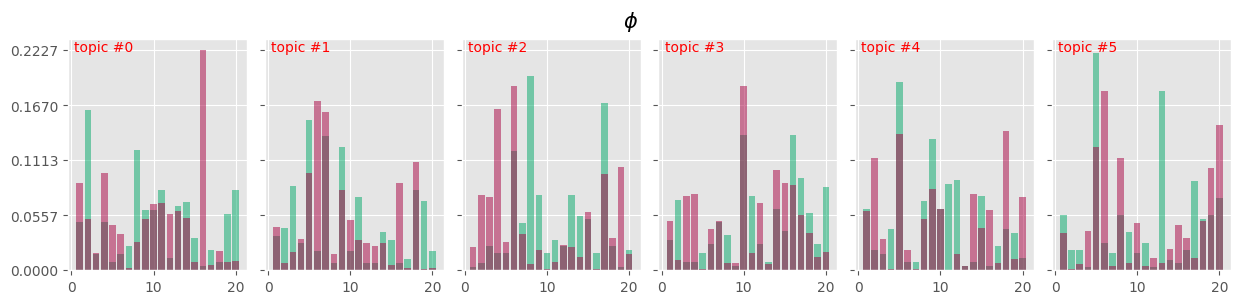

In [13]:
plot_phi(phi, true_phi_kv, n_rows=1)

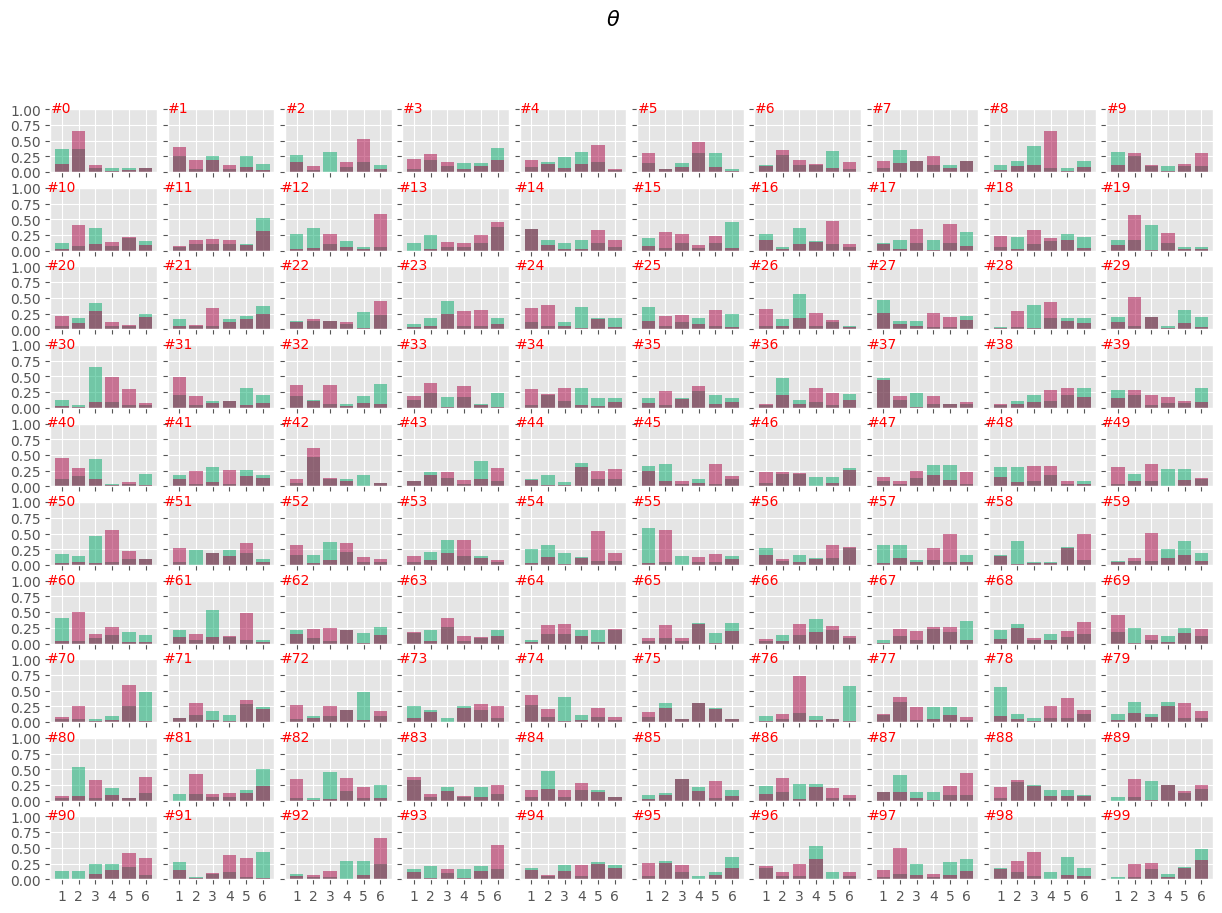

In [14]:
plot_theta(theta, true_theta_dk, n_rows=10)